### **Machine Learning and Content analytics**

#### **Project:** Demographical Characteristics’ Detection (Gender, Age and Ethnicity using Image Classification

### Colored dataset notebook - Pretrained CNN models for gender detection

**Professors:** Haris Papageorgiou, Georgios Perakis

**Students:**
* Mandyli Chrysoula – Charikleia (F2822106)
* Papaloukas Ioannis (F2822110)
* Papidaki Christina (F2822111)
* Taklakoglou – Chidiroglou Argyrios (F2822114)

NOTEBOOK CONTENTS:

- Data loading and overview
- Algorithms, NLP, Architectures/Systems:
  - VGG16
    - Model Evaluation
    - Model Predictions, Confusion Matrix and Evaluation metrics
  - GoogleNet-Inception
    - Model Evaluation
    - Model Predictions, Confusion Matrix and Evaluation metrics
  - ResNet50
    - Model Evaluation
    - Model Predictions, Confusion Matrix and Evaluation metrics
  - EfficientNetBO
    - Model Evaluation
    - Model Predictions, Confusion Matrix and Evaluation metrics
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libraries

import pandas as pd
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, InputLayer, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Setting the paths to the directories

base_directory = '/content/drive/MyDrive/Image Classification/dataset'
train_directory = '/content/drive/MyDrive/Image Classification/dataset/train'
train_female_directory = '/content/drive/MyDrive/Image Classification/dataset/train/female'
train_male_directory = '/content/drive/MyDrive/Image Classification/dataset/train/male'
validation_directory = '/content/drive/MyDrive/Image Classification/dataset/validation'
validation_female_directory = '/content/drive/MyDrive/Image Classification/dataset/validation/female'
validation_male_directory = '/content/drive/MyDrive/Image Classification/dataset/validation/male'
test_directory = '/content/drive/MyDrive/Image Classification/dataset/test'
test_female_directory = '/content/drive/MyDrive/Image Classification/dataset/test/female'
test_male_directory = '/content/drive/MyDrive/Image Classification/dataset/test/male'

In [ ]:
# How we split the images to directories 

num_female_train = len(os.listdir(train_female_directory))
num_male_train = len(os.listdir(train_male_directory))
num_female_test = len(os.listdir(test_female_directory))
num_male_test= len(os.listdir(test_male_directory))
num_female_validation = len(os.listdir(validation_female_directory))
num_male_validation= len(os.listdir(validation_male_directory))

print("Total Training Female Images",num_female_train)
print("Total Training Male Images",num_male_train)
print("------------------------------")
print("Total Validation Female Images",num_female_validation)
print("Total Validation Male Images",num_male_validation)
print("------------------------------")
print("Total Test Female Images", num_female_test)
print("Total Test Male Images",num_male_test)
total_train = num_female_train + num_male_train
total_test = num_female_test + num_male_test
total_validation = num_female_validation + num_male_validation
print("------------------------------")
print("Total Training Images",total_train)
print("Total Validation Images",total_validation)
print("Total Testing Images",total_test)

Total Training Female Images 3000
Total Training Male Images 3000
------------------------------
Total Validation Female Images 500
Total Validation Male Images 500
------------------------------
Total Test Female Images 200
Total Test Male Images 200
------------------------------
Total Training Images 6000
Total Validation Images 1000
Total Testing Images 400


In [ ]:
# Plot the metrics of the models

def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

In [ ]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True)

# **VGG16 Model**

In [ ]:
# Data Augmentation and Generators

image_gen_train = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(batch_size = 32,
                                                     directory = train_directory,
                                                     shuffle= False,
                                                     target_size = (224,224),
                                                     class_mode = 'binary')

image_gen_validation = ImageDataGenerator(rescale=1./255)

validation_data_gen = image_gen_validation.flow_from_directory(batch_size=32,
                                                   directory=validation_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                                   directory=test_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), 
                                                include_top=False,
                                                weights="imagenet")

for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
vgg_model = tf.keras.Model(pre_trained_model.input, x)
vgg_model.compile(optimizer='adam', 
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

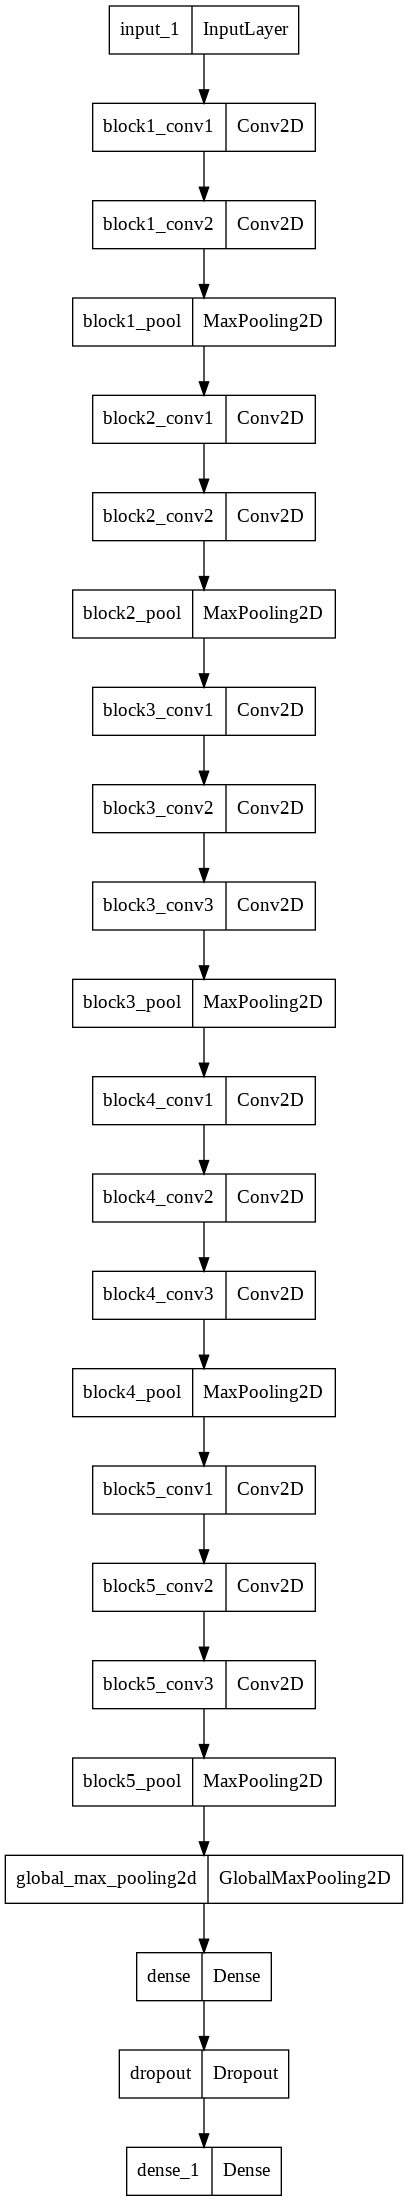

In [ ]:
plot_model(vgg_model)

In [ ]:
vgg_classifier = vgg_model.fit(train_data_gen,
                           steps_per_epoch=(total_train//32),
                           epochs = 30,                          
                           validation_data=validation_data_gen,
                           validation_steps=(total_validation/32),
                           batch_size = 32,
                           callbacks=[es],
                           verbose = 1)

Epoch 1/30
187/187 [==============================] - 377s 2s/step - loss: 0.4701 - accuracy: 0.7842 - val_loss: 0.4935 - val_accuracy: 0.7450
Epoch 2/30
187/187 [==============================] - 35s 186ms/step - loss: 0.4203 - accuracy: 0.8097 - val_loss: 0.3039 - val_accuracy: 0.8720
Epoch 3/30
187/187 [==============================] - 34s 184ms/step - loss: 0.3692 - accuracy: 0.8378 - val_loss: 0.3401 - val_accuracy: 0.8450
Epoch 4/30
187/187 [==============================] - 34s 182ms/step - loss: 0.3397 - accuracy: 0.8494 - val_loss: 0.2686 - val_accuracy: 0.8940
Epoch 5/30
187/187 [==============================] - 35s 188ms/step - loss: 0.4033 - accuracy: 0.8237 - val_loss: 0.4436 - val_accuracy: 0.7630
Epoch 6/30
187/187 [==============================] - 36s 191ms/step - loss: 0.3399 - accuracy: 0.8559 - val_loss: 0.2644 - val_accuracy: 0.8990
Epoch 7/30
187/187 [==============================] - 35s 185ms/step - loss: 0.3628 - accuracy: 0.8413 - val_loss: 0.4382 - val_accu

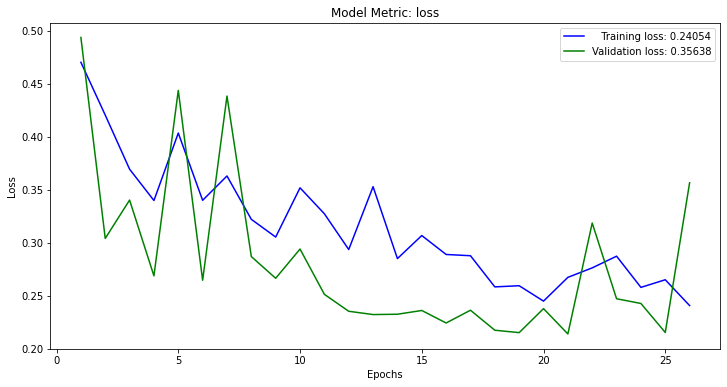

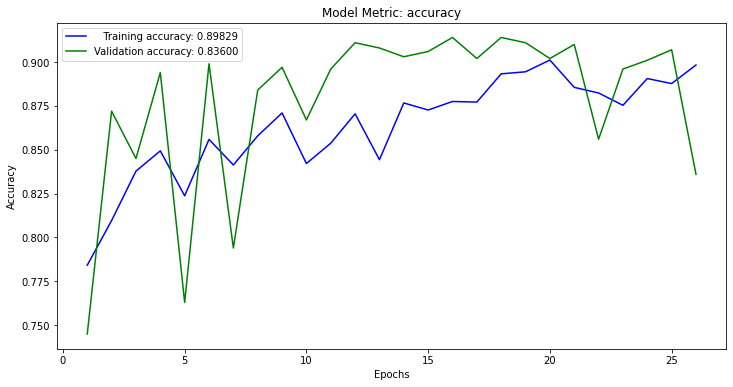

In [ ]:
plot_keras_history(vgg_classifier)

In [ ]:
# vgg_model.save('/content/drive/MyDrive/Image Classification/vgg_model.h5')

In [ ]:
# vgg_model = load_model('/content/drive/MyDrive/Image Classification/vgg_model.h5')
# vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# vgg_model.save_weights('/content/drive/MyDrive/Image Classification/vgg_weights.h5')

In [ ]:
# vgg_weights = vgg_model.load_weights('/content/drive/MyDrive/Image Classification/vgg_weights.h5')

***Evaluation for VGG16 Model***

In [ ]:
result_vgg = vgg_model.evaluate(validation_data_gen,batch_size=32)
print("validation_loss, validation accuracy",result_vgg)

32/32 [==============================] - 813s 26s/step - loss: 0.2162 - accuracy: 0.9090
validation_loss, validation accuracy [0.216172456741333, 0.9089999794960022]


In [ ]:
print(f'Validation loss: {round(result_vgg[0],3)}')
print('Validation accuracy: {:.3f} %'.format(100 * result_vgg[1]))

Validation loss: 0.216
Validation accuracy: 90.900 %


# **GoogleNet** **-** **Inception Model**

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size = 32,
                                                     directory = train_directory,
                                                     shuffle= False,
                                                     target_size = (150,150),
                                                     class_mode = 'binary')

validation_data_gen = image_gen_validation.flow_from_directory(batch_size=32,
                                                   directory=validation_directory,
                                                   shuffle= False,
                                                   target_size=(150, 150),
                                                   class_mode='binary')

test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                                   directory=test_directory,
                                                   shuffle= False,
                                                   target_size=(150, 150),
                                                   class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception.layers:
  print(layer.name)
  layer.trainable = False

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
y = Flatten()(inception.output)
y = Dense(1024, activation='relu')(y)
y = Dropout(0.2)(y)
y = Dense(2, activation='sigmoid')(y)

In [ ]:
inception_model = tf.keras.models.Model(inception.input, y)
inception_model.compile(optimizer = 'adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics = ['accuracy'])

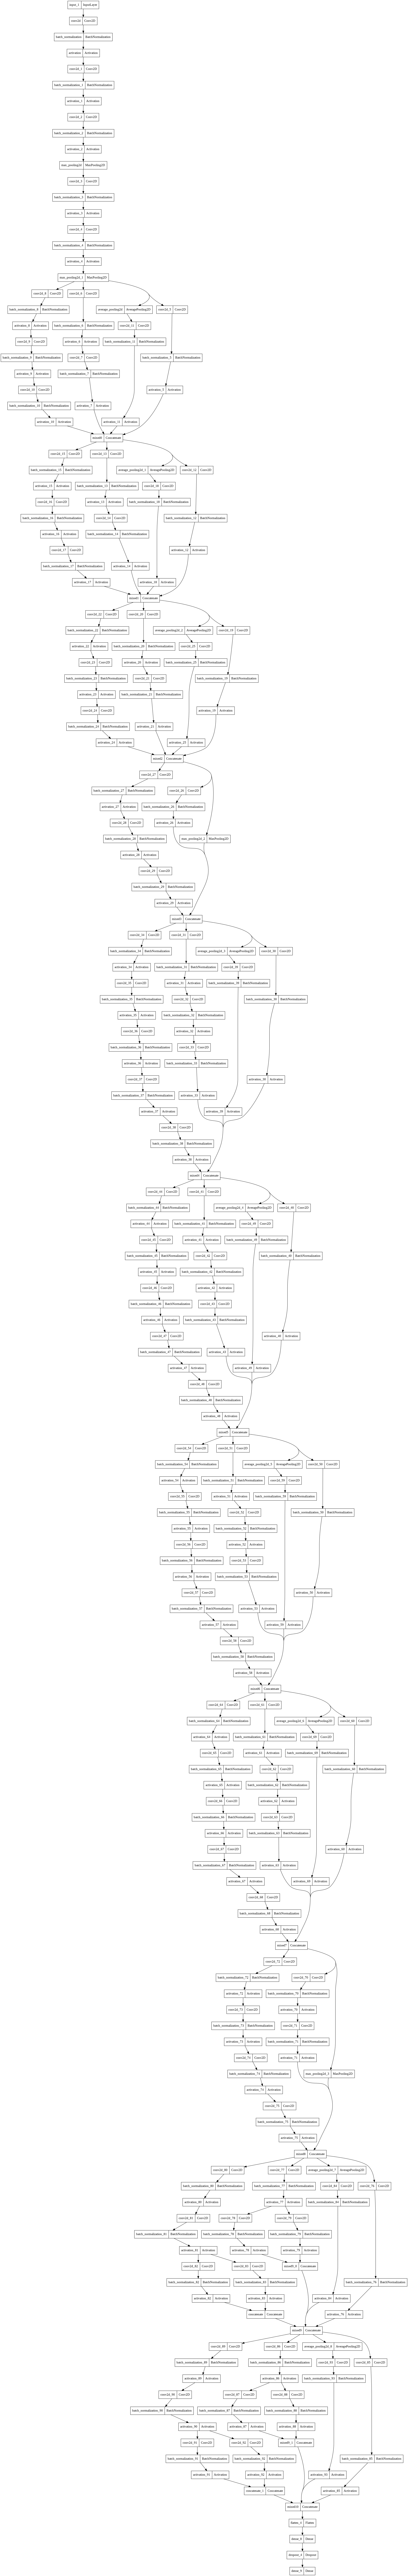

In [ ]:
plot_model(inception_model)

In [ ]:
inception_classifier = inception_model.fit(train_data_gen,
                                           steps_per_epoch=(total_train//32),
                                           epochs = 30,
                                           validation_data=validation_data_gen,
                                           validation_steps=(total_validation/32),
                                           batch_size = 32,
                                           callbacks=[es],
                                           verbose = 1)

Epoch 1/30
187/187 [==============================] - 910s 5s/step - loss: 2.9579 - accuracy: 0.8386 - val_loss: 0.2414 - val_accuracy: 0.9160
Epoch 2/30
187/187 [==============================] - 302s 2s/step - loss: 0.2583 - accuracy: 0.8934 - val_loss: 0.2061 - val_accuracy: 0.9270
Epoch 3/30
187/187 [==============================] - 302s 2s/step - loss: 0.2195 - accuracy: 0.9114 - val_loss: 0.2034 - val_accuracy: 0.9300
Epoch 4/30
187/187 [==============================] - 300s 2s/step - loss: 0.2027 - accuracy: 0.9216 - val_loss: 0.1908 - val_accuracy: 0.9330
Epoch 5/30
187/187 [==============================] - 300s 2s/step - loss: 0.1974 - accuracy: 0.9214 - val_loss: 0.2866 - val_accuracy: 0.8920
Epoch 6/30
187/187 [==============================] - 301s 2s/step - loss: 0.2322 - accuracy: 0.9047 - val_loss: 0.2448 - val_accuracy: 0.8970
Epoch 7/30
187/187 [==============================] - 301s 2s/step - loss: 0.1939 - accuracy: 0.9192 - val_loss: 0.1905 - val_accuracy: 0.9280

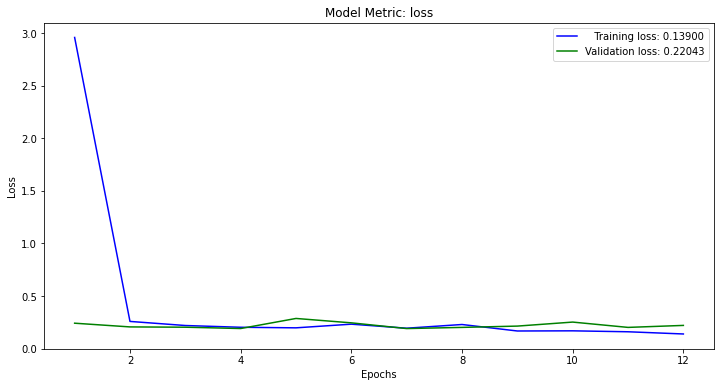

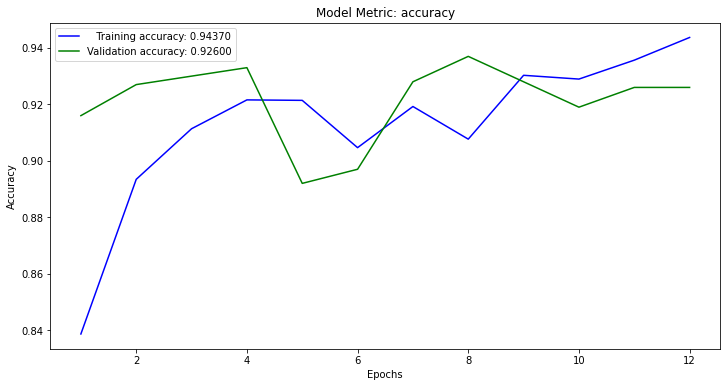

In [ ]:
plot_keras_history(inception_classifier)

In [ ]:
# inception_model.save('/content/drive/MyDrive/Image Classification/inception_model.h5')

In [ ]:
# inception_model = load_model('/content/drive/MyDrive/Image Classification/inception_model.h5')
# inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# inception_model.save_weights('/content/drive/MyDrive/Image Classification/inception_weights.h5')

In [ ]:
# inception_weights = inception_model.load_weights('/content/drive/MyDrive/Image Classification/inception_weights.h5')

***Evaluation for Inception Model***

In [ ]:
result_gnet = inception_model.evaluate(validation_data_gen,batch_size=32)
print("validation_loss, validation accuracy",result_gnet)

32/32 [==============================] - 42s 1s/step - loss: 0.1905 - accuracy: 0.9280
validation_loss, validation accuracy [0.19046205282211304, 0.9279999732971191]


In [ ]:
print(f'Validation loss: {round(result_gnet[0],3)}')
print('Validation accuracy: {:.3f} %'.format(100 * result_gnet[1]))

Validation loss: 0.19
Validation accuracy: 92.800 %


# **ResNet50 Model**

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size = 32,
                                                     directory = train_directory,
                                                     shuffle= True,
                                                     target_size = (224,224),
                                                     class_mode = 'binary')

validation_data_gen = image_gen_validation.flow_from_directory(batch_size=32,
                                                   directory=validation_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                                   directory=test_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [ ]:
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [ ]:
for layer in resnet_model.layers:
  print(layer.name)
  layer.trainable = False

input_4
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
resnet_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

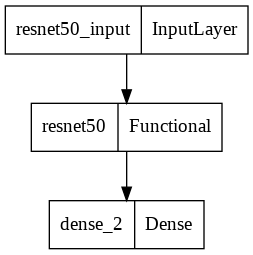

In [ ]:
plot_model(resnet_model)

In [ ]:
resnet_classifier = resnet_model.fit(train_data_gen,
                                           steps_per_epoch=(total_train//32),
                                           epochs = 30,
                                           validation_data=validation_data_gen,
                                           validation_steps=(total_validation/32),
                                           batch_size = 32,
                                           callbacks=[es],
                                           verbose = 1)

Epoch 1/30
187/187 [==============================] - 72s 357ms/step - loss: 1.5757 - accuracy: 0.8098 - val_loss: 1.4975 - val_accuracy: 0.5000
Epoch 2/30
187/187 [==============================] - 67s 356ms/step - loss: 1.2121 - accuracy: 0.8125 - val_loss: 0.6834 - val_accuracy: 0.5500
Epoch 3/30
187/187 [==============================] - 67s 356ms/step - loss: 0.4937 - accuracy: 0.8596 - val_loss: 0.7663 - val_accuracy: 0.5000
Epoch 4/30
187/187 [==============================] - 67s 360ms/step - loss: 0.2142 - accuracy: 0.9268 - val_loss: 0.6759 - val_accuracy: 0.5800
Epoch 5/30
187/187 [==============================] - 68s 363ms/step - loss: 0.1369 - accuracy: 0.9460 - val_loss: 0.4904 - val_accuracy: 0.7800
Epoch 6/30
187/187 [==============================] - 68s 364ms/step - loss: 0.1049 - accuracy: 0.9588 - val_loss: 0.3411 - val_accuracy: 0.8600
Epoch 7/30
187/187 [==============================] - 68s 365ms/step - loss: 0.0912 - accuracy: 0.9648 - val_loss: 0.1527 - val_ac

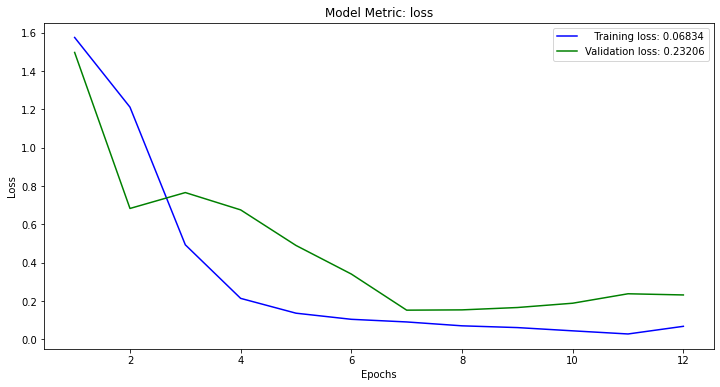

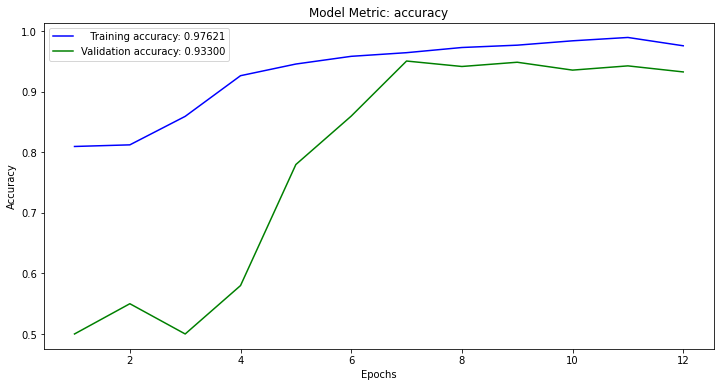

In [ ]:
plot_keras_history(resnet_classifier)

In [ ]:
# resnet_model.save('/content/drive/MyDrive/Image Classification/resnet_model.h5')

In [ ]:
resnet_model = load_model('/content/drive/MyDrive/Image Classification/resnet_model.h5')
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# resnet_model.save_weights('/content/drive/MyDrive/Image Classification/resnet_weights.h5')

In [ ]:
# resnet_weights = resnet_model.load_weights('resnet_weights.h5')

***Evaluation for ResNet50 Model***

In [ ]:
result_resnet = resnet_model.evaluate(validation_data_gen,batch_size=32)
print("validation loss, validation accuracy",result_resnet)

32/32 [==============================] - 3s 105ms/step - loss: 0.1527 - accuracy: 0.9510
validation loss, validation accuracy [0.1526547223329544, 0.9509999752044678]


In [ ]:
print(f'Validation loss: {round(result_resnet[0],3)}')
print('Validation accuracy: {:.3f} %'.format(100 * result_resnet[1]))

Validation loss: 0.153
Validation accuracy: 95.100 %


# **EfficientNetB0 Model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size = 32,
                                                     directory = train_directory,
                                                     shuffle= False,
                                                     target_size = (224,224),
                                                     class_mode = 'binary')

validation_data_gen = image_gen_validation.flow_from_directory(batch_size=32,
                                                   directory=validation_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                                   directory=test_directory,
                                                   shuffle= False,
                                                   target_size=(224, 224),
                                                   class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
efn = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in efn.layers:
  print(layer.name)
  layer.trainable = False

input_8
rescaling_1
normalization_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

In [ ]:
z = GlobalAveragePooling2D(name='avg_pool')(efn.output)
z = BatchNormalization()(z)
z = Dropout(0.7)(z)
z = Dense(2, activation='sigmoid')(z)

In [ ]:
efn_model = tf.keras.models.Model(efn.input, z)
efn_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])

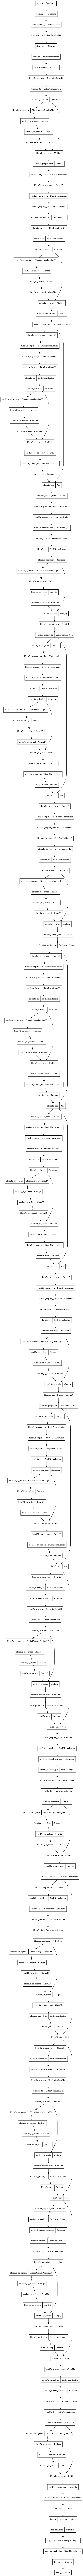

In [ ]:
plot_model(efn_model)

In [ ]:
efn_classifier = efn_model.fit(train_data_gen,
                                           steps_per_epoch=(total_train//32),
                                           epochs = 30,
                                           validation_data=validation_data_gen,
                                           validation_steps=(total_validation/32),
                                           batch_size = 32,
                                           callbacks=[es],
                                           verbose = 1)

Epoch 1/30
187/187 [==============================] - 26s 110ms/step - loss: 0.9873 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
187/187 [==============================] - 20s 106ms/step - loss: 0.9682 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/30
187/187 [==============================] - 19s 103ms/step - loss: 0.9727 - accuracy: 0.4926 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/30
187/187 [==============================] - 19s 103ms/step - loss: 0.9559 - accuracy: 0.4966 - val_loss: 0.6934 - val_accuracy: 0.5010
Epoch 5/30
187/187 [==============================] - 19s 101ms/step - loss: 0.9398 - accuracy: 0.5052 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/30
187/187 [==============================] - 19s 102ms/step - loss: 0.9620 - accuracy: 0.5028 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 6: early stopping


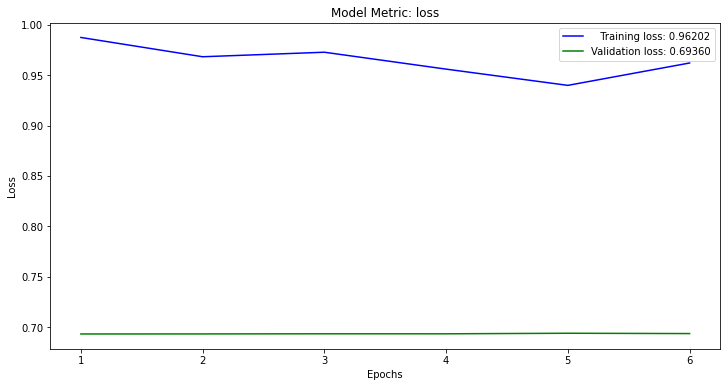

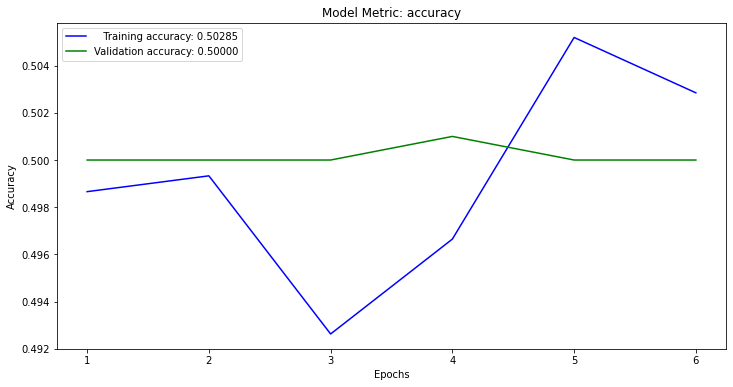

In [ ]:
plot_keras_history(efn_classifier)

In [ ]:
# efn_model.save('/content/drive/MyDrive/Image Classification/efn_model.h5')

In [ ]:
# efn_model = load_model('/content/drive/MyDrive/Image Classification/efn_model.h5')
# efn_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# efn_model.save_weights('/content/drive/MyDrive/Image Classification/efficient_weights.h5')

In [ ]:
# efficient_weights = efn_model.load_weights('/content/drive/MyDrive/Image Classification/efficient_weights.h5')

***Evaluation for EfficientNetB0 Model***

In [ ]:
result_efn = efn_model.evaluate(validation_data_gen,batch_size=32)
print("validation_loss, validation accuracy",result_efn)

32/32 [==============================] - 3s 83ms/step - loss: 0.6932 - accuracy: 0.5000
validation_loss, validation accuracy [0.6932032108306885, 0.5]


In [ ]:
print(f'Validation loss: {round(result_efn[0],3)}')
print('Validation accuracy: {:.3f} %'.format(100 * result_efn[1]))

Validation loss: 0.693
Validation accuracy: 50.000 %


# **Predictions with the best model**

In [ ]:
# Our best model according to evaluation is ResNet50

In [ ]:
y_test_probs = resnet_model.predict(test_data_gen) 
y_test_probs

array([[9.72278714e-01, 1.13482401e-01],
       [9.80634689e-01, 1.89604443e-02],
       [8.17798615e-01, 3.15239400e-01],
       [9.99997020e-01, 9.56283882e-04],
       [1.00000000e+00, 1.72942305e-09],
       [9.99901772e-01, 3.35847237e-03],
       [6.54681683e-01, 2.74480850e-01],
       [9.68809009e-01, 3.37151177e-02],
       [9.99975920e-01, 8.75435024e-03],
       [1.00000000e+00, 9.81350792e-23],
       [8.84189487e-01, 1.69826552e-01],
       [9.79315817e-01, 2.43204944e-02],
       [9.99999046e-01, 1.24381634e-03],
       [9.99542832e-01, 8.44028126e-03],
       [9.99999881e-01, 3.27018998e-03],
       [1.00000000e+00, 1.66059885e-06],
       [1.00000000e+00, 2.49748695e-07],
       [9.97768164e-01, 1.10548967e-02],
       [9.44500089e-01, 1.02677278e-01],
       [9.58771348e-01, 1.29324108e-01],
       [8.53928328e-02, 9.29246962e-01],
       [6.75600171e-01, 4.64017570e-01],
       [9.99923944e-01, 9.65648517e-03],
       [7.23477244e-01, 4.73613262e-01],
       [8.783046

In [ ]:
y_test_pred=np.argmax(y_test_probs, axis=1)
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Text(0.5, 15.0, 'Actual label')

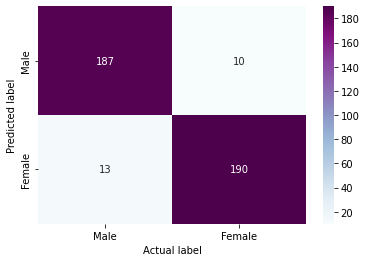

In [ ]:

sns.heatmap(confusion_matrix(y_test_pred,test_data_gen.classes),annot = True, fmt = 'd', cmap = "BuPu", xticklabels = ['Male','Female'] , yticklabels= ['Male','Female'])
plt.ylabel('Predicted label')
plt.xlabel('Actual label')

In [ ]:
print('Classification Report for ResNet50 model')
target_names = ['Male', 'Female']
print(classification_report(test_data_gen.classes, y_test_pred, target_names=target_names))

Classification Report for ResNet50 model
              precision    recall  f1-score   support

        Male       0.95      0.94      0.94       200
      Female       0.94      0.95      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400

